# Credit Card Fraud Detection

[Source Dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud)

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.under_sampling import RandomUnderSampler 
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'png'

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


# EDA 

## General summary

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

**Note:** Features V1, V2, … V28 are the principal components obtained with PCA (already scaled), the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## Missing Values

In [6]:
df.isna().sum().sum()

0

**Note:** The dataset does not contains any missing values.

## Target variable (Class) distribution

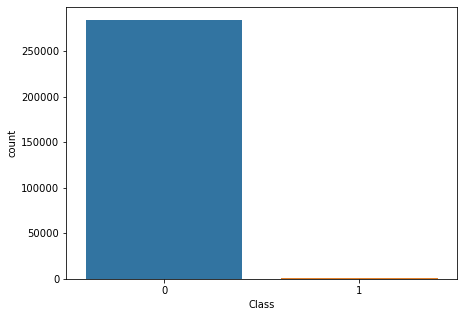

In [7]:
plt.figure(figsize=(7, 5))
sns.countplot('Class', data=df);

In [8]:
df.Class.value_counts(normalize=True).to_frame('Class_perc')

,Class_perc
0,0.998273
1,0.001727


**Note:** Our original dataset is highly imbalanced, ~99.83%  No Frauds vs ~0.17% Frauds.

## Amount & Time Variables Distributions

In [9]:
def show_dist(df, var):
    fig = plt.figure(constrained_layout=True, figsize=(10, 5))
    grid = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
    
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram of %s' % var)
    sns.distplot(df.loc[:, var], norm_hist=True, ax=ax1);
    
    ax2 = fig.add_subplot(grid[0, 2])
    ax2.set_title('Box Plot of %s' % var)
    sns.boxplot(y=df.loc[:, var], ax=ax2);

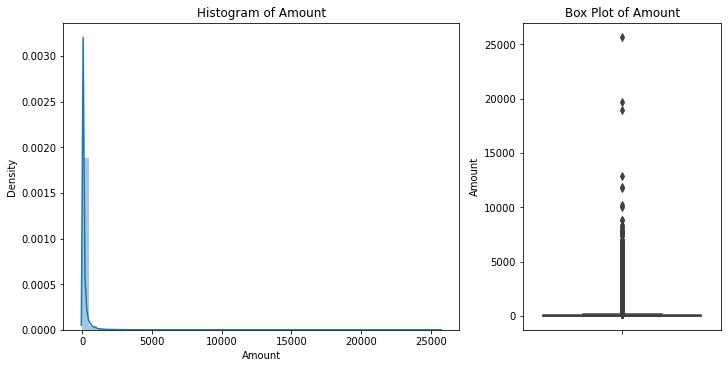

In [10]:
show_dist(df, 'Amount')

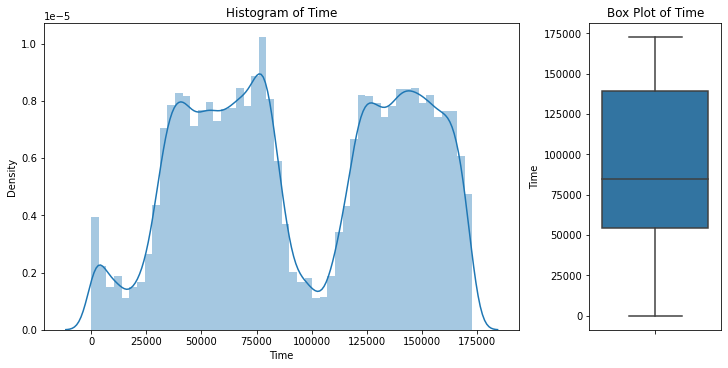

In [11]:
show_dist(df, 'Time')

**Note:** Before further exploration let's perform the above features scaling and create a sub-sample of the original dataframe in order to have an equal amount of Fraud and Non-Fraud transactions.

# Features Engineering

## Amount & Time scaling

In [12]:
df['scaled_amount'] = RobustScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = RobustScaler().fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [13]:
curr_cols = df.columns.tolist()
new_cols = curr_cols[-2:] + curr_cols[:-2]
df = df[new_cols]
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## Splitting the data

In [14]:
X = df.drop('Class', axis=1)
y = df['Class']
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2,
                                                                                    random_state=42, stratify=y)

**Note:** `stratify` parameter ensures us equally-distribution split.<br>
Morever, before proceeding data with the Random UnderSampling technique we have to separate out the original dataframe.

## Random Under-Sampling

In [15]:
Counter(df.Class)

Counter({0: 284315, 1: 492})

In [16]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
new_df = pd.concat([X_res, y_res], axis=1)
new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-0.296793,-0.026340,1.314539,0.590643,-0.666593,0.716564,0.301978,-1.125467,0.388881,-0.288390,...,-0.058040,-0.170307,-0.429655,-0.141341,-0.200195,0.639491,0.399476,-0.034321,0.031692,0
1,-0.249004,-0.401062,-0.798672,1.185093,0.904547,0.694584,0.219041,-0.319295,0.495236,0.139269,...,-0.081298,0.202287,0.578699,-0.092245,0.013723,-0.246466,-0.380057,-0.396030,-0.112901,0
2,-0.097813,-0.347361,-0.391128,-0.245540,1.122074,-1.308725,-0.639891,0.008678,-0.701304,-0.027315,...,0.065716,-0.133485,0.117403,-0.191748,-0.488642,-0.309774,0.008100,0.163716,0.239582,0
3,0.489066,0.374534,-0.060302,1.065093,-0.987421,-0.029567,0.176376,-1.348539,0.775644,0.134843,...,-0.169706,0.355576,0.907570,-0.018454,-0.126269,-0.339923,-0.150285,-0.023634,0.042330,0
4,-0.307413,0.067458,1.848433,0.373364,0.269272,3.866438,0.088062,0.970447,-0.721945,0.235983,...,-0.282777,0.103563,0.620954,0.197077,0.692392,-0.206530,-0.021328,-0.019823,-0.042682,0


In [17]:
Counter(new_df.Class)

Counter({0: 492, 1: 492})

## Resampled Class Distribution

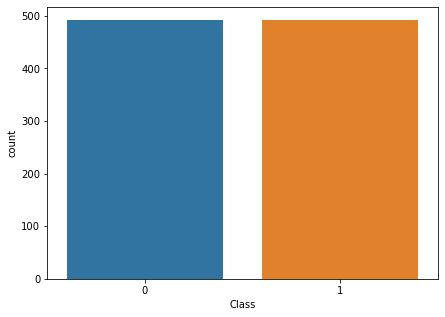

In [18]:
plt.figure(figsize=(7, 5))
sns.countplot('Class', data=new_df);

## Features Matrix Correlation

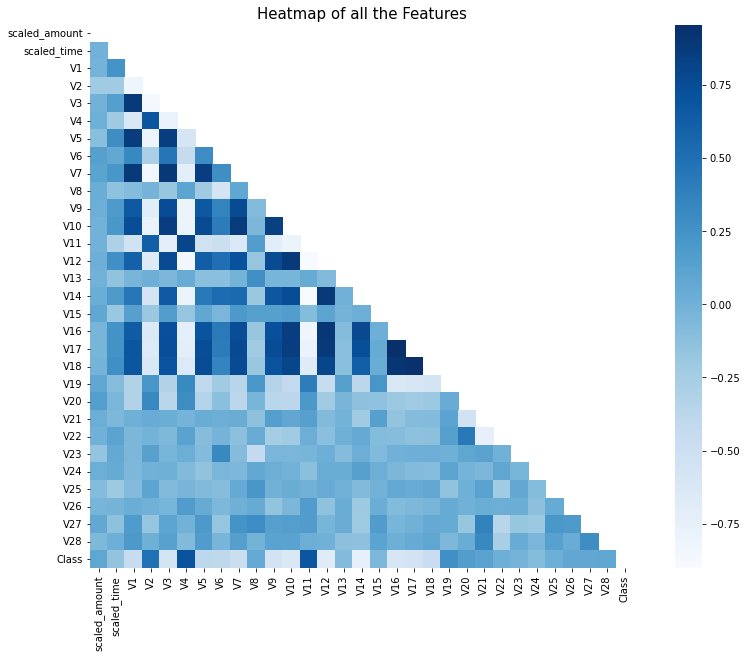

In [19]:
plt.subplots(figsize = (15, 10))
mask = np.zeros_like(new_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(new_df.corr(), cmap="Blues", 
            mask = mask, square=True);
plt.title("Heatmap of all the Features", fontsize=15);

 - **Negative Correlations:** V17, V14, V12 and V10 are negatively correlated with Class. Notice how the lower these values are, the more likely the end result will be a fraud transaction.

- **Positive Correlations:** V2, V4, V11, and V19 are positively correlated with Class. Notice how the higher these values are, the more likely the end result will be a fraud transaction.

In [20]:
def show_corr(df, features, ncol):
    fig = plt.figure(constrained_layout=True, figsize=(12, 4))
    grid = gridspec.GridSpec(ncols=ncol, nrows=1, figure=fig)
    
    for idx, feature in enumerate(features):
        ax = fig.add_subplot(grid[0, idx])
        ax.set_title('%s vs Class' % feature)
        sns.boxplot(x=df.Class, y=df.loc[:, feature], ax=ax)

**Negative Correlations:**

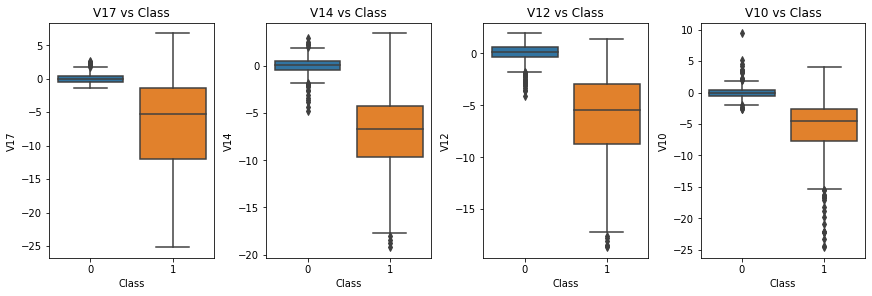

In [21]:
show_corr(new_df, features=['V17', 'V14', 'V12', 'V10'], ncol=4)

**Positive Correlations:**

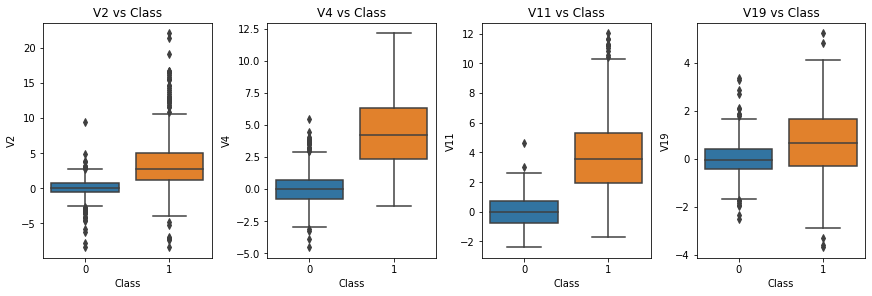

In [22]:
show_corr(new_df, features=['V2', 'V4', 'V11', 'V19'], ncol=4)

## Removing outliers

**Note:** Our main aim in this section is to remove outliers from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models.

In [23]:
def remove_outliers(new_df, features):
    Q1 = new_df[features].quantile(0.25)
    Q3 = new_df[features].quantile(0.75)
    IQR = Q3 - Q1
    return new_df[~((new_df[features] < (Q1 - 1.5 * IQR)) |(new_df[features] > (Q3 + 1.5 * IQR))).any(axis=1)]        

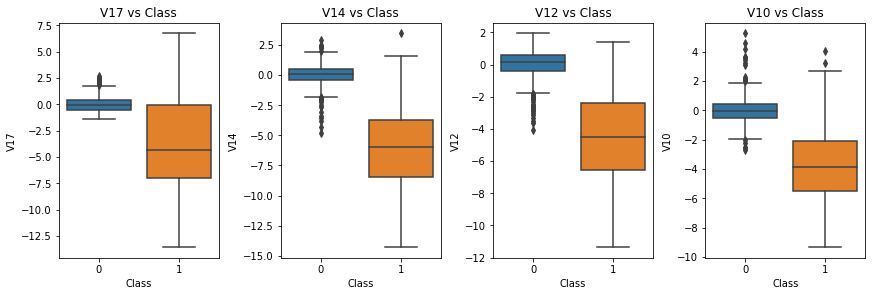

In [24]:
new_df = remove_outliers(new_df=new_df, features=['V17', 'V14', 'V12', 'V10'])
show_corr(new_df, features=['V17', 'V14', 'V12', 'V10'], ncol=4)

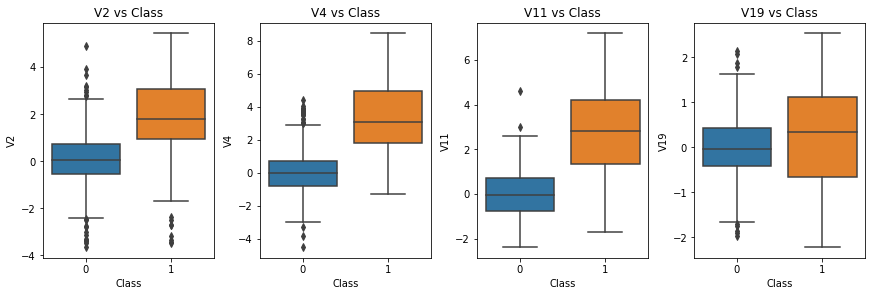

In [25]:
new_df = remove_outliers(new_df=new_df, features=['V2', 'V4', 'V11', 'V19'])
show_corr(new_df, features=['V2', 'V4', 'V11', 'V19'], ncol=4)

# Modeling (RandomUnderSampled Data)

## Training Model

In [26]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
def create_models():
    logreg = LogisticRegression()
    svc = SVC()
    rfc = RandomForestClassifier()
    xgb = XGBClassifier(eval_metric='mlogloss')
    
    return [logreg, svc, rfc, xgb]

In [28]:
def fit_models(X_train, y_train, models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = {'precision': 'precision_macro',
               'recall': 'recall_macro',
               'accuracy': 'accuracy',
               'auc': 'roc_auc'}
    cv_results = []
    
    for model in models:
        cv_model = cross_validate(model, X_train, y_train, scoring=scoring, cv=kfold)
        cv_results.append([cv_model['test_precision'].mean(), cv_model['test_recall'].mean(),
                           cv_model['test_accuracy'].mean(), cv_model['test_auc'].mean()])
    
    return cv_results

In [29]:
def show_cv_results(cv_results):
    cvr_df = pd.DataFrame(index=['Logisitc Regression', 'SVM', 'Random Forest', 'XGBoost'],
                          data=cv_results, columns=['precision', 'recall', 'accuracy', 'AUC'])
    return cvr_df

In [30]:
models = create_models()
cv_results = fit_models(X_train, y_train, models)
show_cv_results(cv_results)

,precision,recall,accuracy,AUC
Logisitc Regression,0.936081,0.926463,0.934996,0.974623
SVM,0.941360,0.916463,0.931821,0.973010
Random Forest,0.940657,0.919955,0.933421,0.967934
XGBoost,0.934018,0.922642,0.931821,0.967348


**Note:** Almost all classifiers achieved quite similar scores on the resampled training data. For further analysis, I decided to use only one out of the four classifiers I tested before. My choice is XGBoost, mainly because of the fact that it is widely known for its superiority over the other classification alghoritms.

## Hyperparameter Tuning using Bayesian Optimization

In [31]:
def xgb_bayes_opt(max_depth, learning_rate, n_estimators, subsample, gamma):
    params_xgb = {}
    params_xgb['max_depth'] = round(max_depth)
    params_xgb['learning_rate'] = learning_rate
    params_xgb['n_estimators'] = round(n_estimators)
    params_xgb['subsample'] = subsample
    params_xgb['gamma'] = gamma
    
    return cross_val_score(XGBClassifier(eval_metric='mlogloss', **params_xgb),
                           X_train, y_train, cv=5, scoring='roc_auc').mean()

In [32]:
params_bounds = {'learning_rate': (0.01, 1.0),
                 'n_estimators': (100.0, 1000.0),
                 'max_depth': (4.0,10.0), 
                 'subsample': (0.5, 1.0),
                 'gamma': (0.0, 5.0)}

optimizer = BayesianOptimization(f=xgb_bayes_opt, pbounds=params_bounds, random_state=42) 
optimizer.maximize()
params_result = optimizer.max['params']
params_result['max_depth'] = round(params_result['max_depth'])
params_result['n_estimators'] = round(params_result['n_estimators'])
params_result

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.9574   |  1.873    |  0.9512   |  8.392    |  638.8    |  0.578    |
|  2        |  0.9747   |  0.78     |  0.0675   |  9.197    |  641.0    |  0.854    |
|  3        |  0.9668   |  0.1029   |  0.9702   |  8.995    |  291.1    |  0.5909   |
|  4        |  0.9723   |  0.917    |  0.3112   |  7.149    |  488.8    |  0.6456   |
|  5        |  0.9726   |  3.059    |  0.1481   |  5.753    |  429.7    |  0.728    |
|  6        |  0.9743   |  3.293    |  0.08483  |  5.763    |  429.6    |  0.7593   |
|  7        |  0.9623   |  4.674    |  0.497    |  5.684    |  429.0    |  0.5084   |
|  8        |  0.9692   |  0.2317   |  0.4964   |  8.944    |  641.8    |  0.5572   |
|  9        |  0.964    |  1.396    |  0.9921   |  9.828    |  640.7    |  0.7107   |
|  10       |  0.9731   |  1.632    |  0.107    |  9.3

{'gamma': 0.2647628903796234,
 'learning_rate': 0.18630527754206394,
 'max_depth': 6,
 'n_estimators': 641,
 'subsample': 0.7796431247224216}

In [33]:
xgb = XGBClassifier(eval_metric='mlogloss', **params_result)

## Hyperparameter Tuning using HyperOpt

In [34]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

params_bounds = {'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
                 'n_estimators': hp.uniform('n_estimators', 100.0, 1000.0),
                 'max_depth': hp.uniform('max_depth', 4.0, 10.0), 
                 'subsample': hp.uniform('subsample', 0.5, 1.0),
                 'gamma': hp.uniform('gamma', 0.0, 5.0)}

In [35]:
def fun(params_bounds):
    model = XGBClassifier(eval_metric='mlogloss',
                          learning_rate = params_bounds['learning_rate'],
                          n_estimators = round(params_bounds['n_estimators']),
                          max_depth = round(params_bounds['max_depth']),
                          subsample = params_bounds['subsample'],
                          gamma = params_bounds['gamma'])
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', error_score='raise').mean()
    
    return {'loss': -score, 'status': STATUS_OK}

In [36]:
trials = Trials()
best = fmin(fn=fun,
            space=params_bounds,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)
best['max_depth'] = round(best['max_depth'])
best['n_estimators'] = round(best['n_estimators'])
best

100%|████████████████████████████████████████████████| 30/30 [01:03<00:00,  2.12s/trial, best loss: -0.975454109382681]


{'gamma': 3.43587888515421,
 'learning_rate': 0.3077560707565117,
 'max_depth': 10,
 'n_estimators': 996,
 'subsample': 0.8388029886721918}

**Note**: We will use params from the BayesianOptimization anyway. HyperOpt is just for the presentation case as an alternative library, in general results should be similar.

## Feature Importances

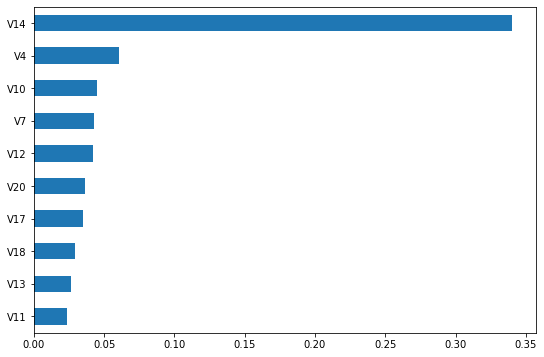

In [37]:
xgb.fit(X_train, y_train)
feat_importances = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values().nlargest(10)
feat_importances.sort_values().plot(kind='barh', figsize=[9, 6]);

## Testing Model

**Note:** Change
to the class distribution is only applied to the training dataset. The intent is to influence the fit
of the models. The sampling is not applied to the test dataset used to evaluate the
performance of a model. Now, we use the whole original dataset to **predict** results.

In [38]:
xgb.fit(X_train, y_train)
prediction = xgb.predict(original_Xtest)

In [39]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score

data=[[precision_score(original_ytest, prediction),
       recall_score(original_ytest, prediction),
       accuracy_score(original_ytest, prediction),
       roc_auc_score(original_ytest, prediction)]]
result_df = pd.DataFrame(index=['XGBoost'],
                         data=data, columns=['precision', 'recall', 'accuracy', 'AUC']).T
result_df

,XGBoost
precision,0.045898
recall,0.959184
accuracy,0.965626
AUC,0.962410


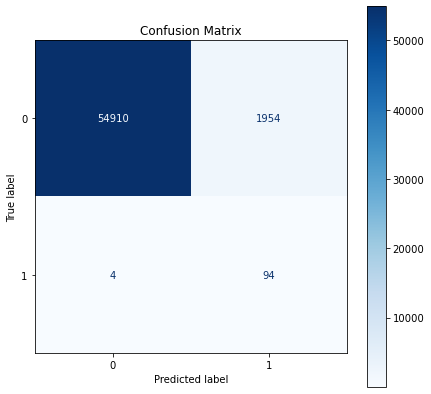

In [40]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Confusion Matrix')
plot_confusion_matrix(xgb, original_Xtest, original_ytest, cmap='Blues', ax=ax);

**Note:** Our model has a very low `precision` with very high `recall` at the same time. Well, it depends on the business problem which type of metric we want to maximize, in our case we want to have rather higher `recall` than `precision`. It is acceptable to predict more 0 as 1 rather than more 1 as 0 (1 fradulent, 0 non-fradulent). However, we do not want to worry our clients too much that they their transaction was fraudulent, let's try to adjust the treshold to improve the `precision` as well.

## Threshold tuning

Best Threshold=0.998936, F-Score=0.738


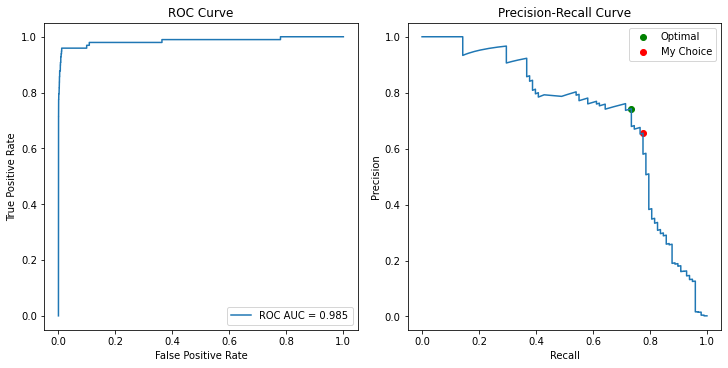

In [41]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

y_pred_proba = xgb.predict_proba(original_Xtest)[:, 1]
fpr, tpr, _ = metrics.roc_curve(original_ytest,  y_pred_proba)
auc = metrics.roc_auc_score(original_ytest, y_pred_proba)

ax1 = fig.add_subplot(grid[0, 0])
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, tpr, label="ROC AUC = " + str(round(auc, 3)))
ax1.legend(loc=4);

y_pred_proba = xgb.predict_proba(original_Xtest)[:, 1]
precision_, recall_, thresholds = metrics.precision_recall_curve(original_ytest, y_pred_proba)
fscore_ = (2 * precision_ * recall_) / (precision_ + recall_)
ix = np.argmax(fscore_)
my_ix = 42699
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore_[ix]))

ax2 = fig.add_subplot(grid[0, 1])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.plot(recall_, precision_)
ax2.scatter(recall_[ix], precision_[ix], marker='o', color='green', label='Optimal');
ax2.scatter(recall_[my_ix], precision_[my_ix], marker='o', color='red', label='My Choice');

plt.legend();

In [42]:
threshold_tuned_pred = [1 if i >= thresholds[my_ix] else 0 for i in xgb.predict_proba(original_Xtest)[:, -1]]

In [43]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score

data=[[precision_score(original_ytest, prediction), precision_score(original_ytest, threshold_tuned_pred)],
      [recall_score(original_ytest, prediction), recall_score(original_ytest, threshold_tuned_pred)],
      [accuracy_score(original_ytest, prediction), accuracy_score(original_ytest, threshold_tuned_pred)],
      [roc_auc_score(original_ytest, prediction), roc_auc_score(original_ytest, threshold_tuned_pred)]]

result_df = pd.DataFrame(data=data,
                         columns=['before', 'after'],
                         index=['precision', 'recall', 'accuracy', 'AUC'])
result_df

,before,after
precision,0.045898,0.655172
recall,0.959184,0.775510
accuracy,0.965626,0.998912
AUC,0.962410,0.887403


**Note**: The most optimal threshold results with `precison` = 0.74 and `recall` = 0.73. However, we want to have recall slightly better than the precision, so I have decided to move the threshold manually a little bit away from the optimal so as to have the `recall` higher than the `precision`. Now, it results with `recall` = 0.78 and `precision` = 0.66.

# Modeling (Original Data)

## Training Model

In [44]:
models = create_models()
cv_results = fit_models(original_Xtrain, original_ytrain, models)
show_cv_results(cv_results)

,precision,recall,accuracy,AUC
Logisitc Regression,0.936036,0.812919,0.999210,0.976473
SVM,0.960454,0.846385,0.999381,0.943352
Random Forest,0.968065,0.880987,0.999508,0.950257
XGBoost,0.969545,0.887264,0.999535,0.980804


**Note:** Similarly as before, let's choose XGBoost for the further exploration.

In [45]:
xgb = models[3]
xgb

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='mlogloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

## Testing Model

In [46]:
xgb.fit(original_Xtrain, original_ytrain)
prediction = xgb.predict(original_Xtest)

In [47]:
data=[[precision_score(original_ytest, prediction),
       recall_score(original_ytest, prediction),
       accuracy_score(original_ytest, prediction),
       roc_auc_score(original_ytest, prediction)]]
result_df = pd.DataFrame(index=['XGBoost'],
                         data=data, columns=['precision', 'recall', 'accuracy', 'AUC']).T
result_df

,XGBoost
precision,0.920455
recall,0.826531
accuracy,0.999579
AUC,0.913204


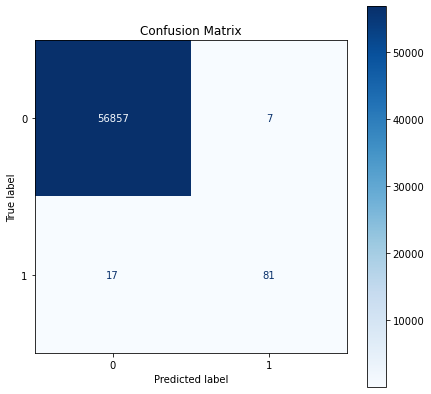

In [48]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(7, 7))
plt.title('Confusion Matrix')
plot_confusion_matrix(xgb, original_Xtest, original_ytest, cmap='Blues', ax=ax);

**Note**: At first glance our predicion using Original Data for training model looks better than on the RUS Data. We received both very high `precision` = 0.92 as well as `recall` = 0.83. Let's explore thresholds.

## Threshold tuning

Best Threshold=0.299159, F-Score=0.889


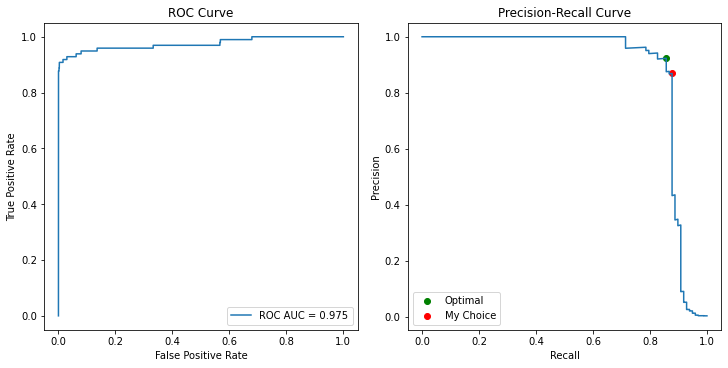

In [49]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
grid = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

y_pred_proba = xgb.predict_proba(original_Xtest)[:, 1]
fpr, tpr, _ = metrics.roc_curve(original_ytest,  y_pred_proba)
auc = metrics.roc_auc_score(original_ytest, y_pred_proba)

ax1 = fig.add_subplot(grid[0, 0])
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, tpr, label="ROC AUC = " + str(round(auc, 3)))
ax1.legend(loc=4);

y_pred_proba = xgb.predict_proba(original_Xtest)[:, 1]
precision_, recall_, thresholds = metrics.precision_recall_curve(original_ytest, y_pred_proba)
fscore_ = (2 * precision_ * recall_) / (precision_ + recall_)
ix = np.argmax(fscore_)
my_ix = 37755
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore_[ix]))

ax2 = fig.add_subplot(grid[0, 1])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.plot(recall_, precision_)
ax2.scatter(recall_[ix], precision_[ix], marker='o', color='green', label='Optimal');
ax2.scatter(recall_[my_ix], precision_[my_ix], marker='o', color='red', label='My Choice');

plt.legend();

In [50]:
threshold_tuned_pred = [1 if i >= thresholds[my_ix] else 0 for i in xgb.predict_proba(original_Xtest)[:, -1]]

In [51]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score

data=[[precision_score(original_ytest, prediction), precision_score(original_ytest, threshold_tuned_pred)],
      [recall_score(original_ytest, prediction), recall_score(original_ytest, threshold_tuned_pred)],
      [accuracy_score(original_ytest, prediction), accuracy_score(original_ytest, threshold_tuned_pred)],
      [roc_auc_score(original_ytest, prediction), roc_auc_score(original_ytest, threshold_tuned_pred)]]

result_df = pd.DataFrame(data=data,
                         columns=['before', 'after'],
                         index=['precision', 'recall', 'accuracy', 'AUC'])
result_df

,before,after
precision,0.920455,0.868687
recall,0.826531,0.877551
accuracy,0.999579,0.999561
AUC,0.913204,0.938661


**Note**: The most optimal threshold results with `precison` = 0.92 and `recall` = 0.86. However, we want to have recall slightly better than the precision, so I have decided to move the threshold manually a little bit away from the optimal so as to have the `recall` higher than the `precision`. Now, it results with `recall` = 0.88 and `precision` = 0.87.

# Summary

Finally, training our XGBoost model on Original Data turned out to be more efficient than on the RUS Data.\
We received a following final results:

In [52]:
data=[[precision_score(original_ytest, threshold_tuned_pred),
       recall_score(original_ytest, threshold_tuned_pred),
       accuracy_score(original_ytest, threshold_tuned_pred),
       roc_auc_score(original_ytest, threshold_tuned_pred)]]

final_df = pd.DataFrame(index=['XGBoost'],
                        data=data,
                        columns=['precision', 'recall', 'accuracy', 'AUC']).T
final_df

,XGBoost
precision,0.868687
recall,0.877551
accuracy,0.999561
AUC,0.938661
